In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
%config InlineBackend.figure_format = 'retina'
import wave

from sklearn.preprocessing import LabelEncoder, minmax_scale
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import moviepy.editor as mp

In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv")

### Preprocessing - Normalizing, Pre-emphasis (need to add windowing/framing)

test on one file

In [3]:
f =  wave.open(r"wav_files/train/dia0_utt0.wav","rb")
nchannels, sampwidth, framerate, nframes = f.getparams()[:4]

In [4]:
print("number of channels: ", nchannels)
print("number of quantization bits: ",sampwidth)
print("sampling frequency: ", framerate)
print("number of sampling points: ",nframes)

number of channels:  2
number of quantization bits:  2
sampling frequency:  44100
number of sampling points:  250929


In [5]:
data,sr = librosa.load("wav_files/train/dia0_utt0.wav", sr =framerate )
sr

44100

In [6]:
str_data = f.readframes(nframes)

In [7]:
wave_data = np.fromstring(str_data, dtype=np.int16)
wave_data

array([ -187,    28,  -494, ..., -2158, -1791, -2040], dtype=int16)

__normalize__ - adjust the volume of audio files to a standard set level; if this isn’t done, the volume can differ greatly from word to word, and the file can end up unable to be processed clearly.

In [8]:
wave_data = wave_data/(max(abs(wave_data)))

In [9]:
len(wave_data)

501858

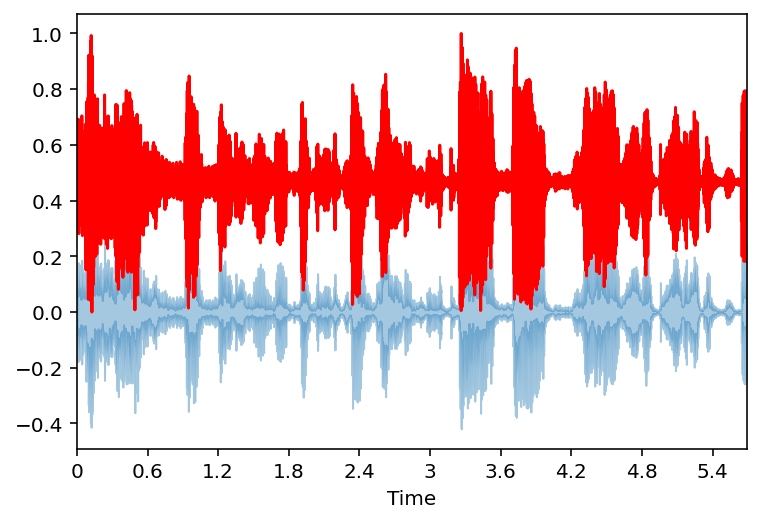

In [10]:
#min = minimum value for each row of the vector signal
#max = maximum value for each row of the vector signal
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)
time = np.arange(0, len(data))/sr
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(data, sr=sr, alpha=0.4)
plt.plot(time, normalize(data), color='r')

In [11]:
norm_y = normalize(data)

__pre-emphasis__ - boosting only the signal’s high-frequency components, while leaving the low-frequency components in their original states. This is done in order to compensate the high-frequency section, which is suppressed naturally when humans make sounds.

In [12]:
y_filt = librosa.effects.preemphasis(norm_y)

In [13]:
len(y_filt)

250929

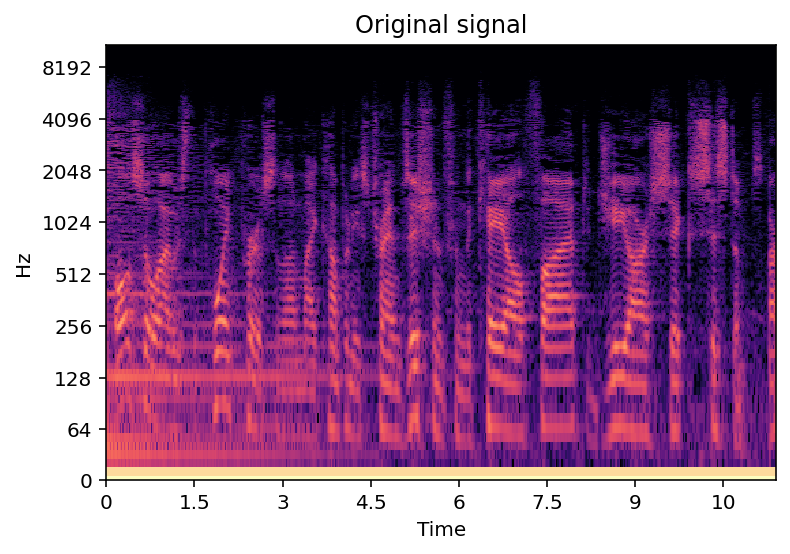

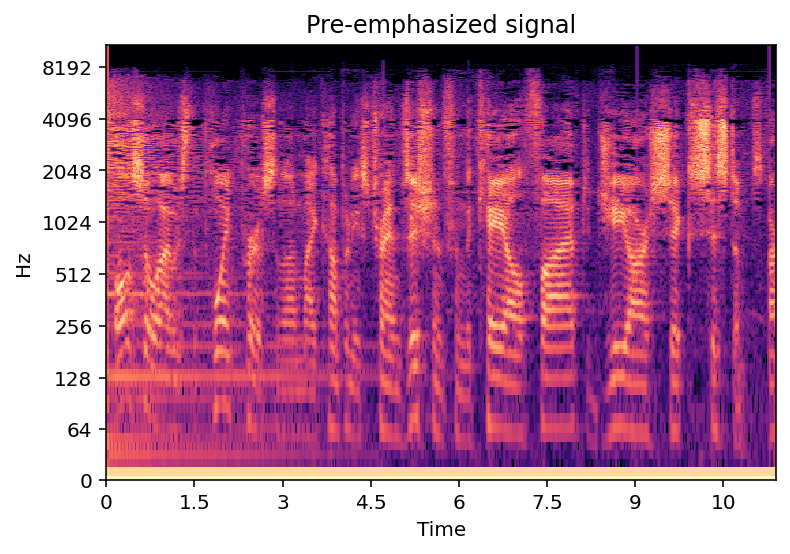

In [14]:
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(norm_y)), ref=np.max)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)

librosa.display.specshow(S_orig, y_axis='log', x_axis='time')
plt.title('Original signal')
plt.show()
librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
plt.title('Pre-emphasized signal')
plt.show()

In [15]:
lpc_test = librosa.lpc(y_filt, 44)

In [16]:
lpc_test.shape

(45,)

In [17]:
lpc_test

array([ 1.0000000e+00, -2.7671983e+00,  4.4124894e+00, -5.0720997e+00,
        4.6712036e+00, -3.5269382e+00,  1.9642309e+00, -4.6436721e-01,
       -6.0950470e-01,  1.0486401e+00, -9.5438915e-01,  4.7597247e-01,
        2.2813387e-02, -3.8489452e-01,  5.0363690e-01, -3.4385511e-01,
        2.7182085e-02,  2.2594449e-01, -2.8097239e-01,  1.6439609e-01,
        7.5318045e-03, -1.5627030e-01,  1.4702962e-01, -4.7260467e-02,
       -7.0375651e-02,  1.1492605e-01, -8.7090865e-02, -5.6071188e-03,
        8.7676972e-02, -8.9210764e-02,  4.6549622e-02,  2.8427023e-02,
       -7.8683645e-02,  5.2934662e-02,  1.6133429e-02, -6.8130270e-02,
        3.7255514e-02,  1.3422495e-02, -9.8669887e-02,  1.1719474e-01,
       -9.5097788e-02,  3.1363141e-02,  7.5369142e-04, -8.1355274e-03,
        2.9229904e-03], dtype=float32)

In [18]:
def preprocess(file):
    data,sr = librosa.load(file, sr = framerate)
    norm_y = normalize(data)
    y_filt = librosa.effects.preemphasis(norm_y)
    return y_filt

In [19]:
speaker_df = pd.read_csv('speaker_df.csv')
speaker_df.head()

,Speaker,Dialogue_ID,Utterance_ID,mel
0,Chandler,0,0,"[array([-40.785557, -31.903383, -28.509054, -2..."
1,The Interviewer,0,1,"[array([-46.091118, -41.26459 , -34.173096, -2..."
2,Chandler,0,2,"[array([-49.231205, -42.710953, -39.304115, -3..."
3,The Interviewer,0,3,"[array([-45.178123, -41.165024, -38.436745, -3..."
4,Chandler,0,4,"[array([-48.915817, -44.924217, -41.524128, -3..."


In [20]:
speaker_df = speaker_df.drop('mel', axis = 1)
speaker_df.head()

,Speaker,Dialogue_ID,Utterance_ID
0,Chandler,0,0
1,The Interviewer,0,1
2,Chandler,0,2
3,The Interviewer,0,3
4,Chandler,0,4


#### LPC (Linear Prediction Coefficients)

In [102]:
# LPC of files
lpcs = []
for dia, utt in zip(speaker_df['Dialogue_ID'], speaker_df['Utterance_ID']):
    if ((dia == 125) and (utt == 3)):
        continue
    elif ((dia == 795) and (utt == 0)):
        continue
    else:
        file = f"wav_files/train/dia{dia}_utt{utt}.wav".format(dia,utt)
        lpc = librosa.lpc(preprocess(file),44)
        lpcs.append([lpc])
        print(dia, utt)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
7 0
7 1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
10 0
10 1
10 2
10 3
10 4
10 5
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
13 0
13 1
13 2
13 3
14 0
14 1
14 2
14 3
14 4
14 5
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
15 16
15 17
15 18
15 19
15 20
15 21
15 22
16 0
16 1
16 2
16 3
16 4
16 5
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 0
19 1
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 1

160 12
160 13
160 14
160 15
160 16
160 17
160 18
161 0
161 1
161 2
161 3
161 4
161 5
162 0
162 1
163 0
163 1
163 2
163 3
163 4
163 5
163 6
163 7
163 8
163 9
163 10
164 0
164 1
164 2
164 3
164 4
164 5
164 6
164 7
164 8
164 9
165 0
165 1
165 2
165 3
165 4
165 5
165 6
165 7
165 8
165 9
165 10
165 11
165 12
165 13
165 14
165 15
165 16
165 17
165 18
165 19
166 0
166 1
166 2
167 0
167 1
167 2
167 3
167 4
167 5
167 6
167 7
167 8
167 9
167 10
167 11
167 12
168 0
168 1
168 2
168 3
168 4
168 5
168 6
168 7
168 8
168 9
168 10
168 11
168 12
168 13
168 14
169 0
169 1
169 2
170 0
170 1
170 2
170 3
170 4
170 5
170 6
170 7
170 8
170 9
170 10
170 11
171 0
171 1
171 2
171 3
171 4
171 5
171 6
171 7
172 0
172 1
172 3
172 4
172 5
172 6
172 7
172 8
172 10
173 0
173 1
173 2
173 3
173 4
173 5
173 6
173 7
173 8
173 10
174 0
174 1
174 2
174 3
174 4
174 5
174 6
174 7
175 0
175 1
175 2
175 3
175 4
175 5
175 6
175 7
175 8
175 9
175 10
175 11
176 0
176 1
176 2
176 4
176 5
176 6
176 7
176 8
176 9
176 10
177 0
177 1
1

297 2
297 3
297 4
297 5
297 6
297 7
297 8
297 9
298 0
298 1
298 2
298 3
298 4
298 5
298 6
299 0
299 1
299 2
299 3
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
300 10
300 11
300 12
300 14
300 15
301 0
301 1
301 2
301 3
301 4
301 6
301 7
301 8
301 9
301 10
301 11
301 12
301 13
301 14
301 15
301 16
302 0
302 1
302 2
302 3
302 4
302 5
302 6
302 7
302 8
302 9
302 10
303 0
303 1
304 0
304 1
304 2
304 3
304 4
304 5
304 6
304 7
304 8
304 9
304 10
305 0
305 1
305 2
305 3
305 4
305 5
305 6
305 7
305 8
305 9
305 10
305 11
305 12
305 13
305 14
306 0
306 1
306 2
306 3
306 4
306 5
306 6
306 7
307 0
307 1
307 2
307 3
307 4
307 5
307 6
307 7
307 8
307 9
307 10
307 11
307 12
308 0
308 1
308 2
308 3
308 4
308 5
309 0
309 1
309 2
309 3
309 4
310 0
310 1
310 2
310 3
310 4
310 5
310 6
311 0
311 1
311 2
311 3
311 4
311 5
311 6
311 7
311 8
311 9
311 10
311 11
311 12
312 0
312 1
312 2
312 3
312 4
312 5
312 6
312 7
312 8
312 9
312 10
312 11
312 12
312 13
312 14
312 15
312 16
312 17
312 18
312 19

445 9
445 10
445 11
445 12
445 13
445 14
445 15
445 16
445 17
445 18
445 19
445 20
446 0
446 1
446 2
446 3
446 4
446 5
446 6
446 7
446 8
446 9
446 10
446 11
446 12
446 13
446 14
446 15
446 16
446 17
446 18
446 19
447 0
447 1
447 2
448 0
448 1
448 2
448 3
448 4
448 5
448 6
448 7
448 8
448 9
448 10
448 11
449 0
449 1
449 2
449 3
449 4
449 5
449 6
449 7
449 8
449 9
449 10
449 11
449 12
449 13
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
450 10
450 11
450 12
450 13
450 14
450 15
450 16
450 17
450 18
450 19
450 20
450 21
450 22
450 23
451 0
451 1
451 2
451 3
451 4
451 5
451 6
451 7
452 0
452 1
452 2
452 3
452 4
453 0
453 1
454 0
454 1
454 2
455 0
455 1
455 2
455 3
455 4
455 5
455 6
455 7
455 8
455 9
455 10
455 11
455 12
455 13
455 14
455 15
455 16
455 17
456 0
456 1
456 2
456 3
456 4
456 5
456 6
456 7
456 8
456 9
456 10
456 11
457 0
457 1
457 2
457 3
457 4
457 5
457 6
457 7
457 8
457 9
457 10
457 11
457 12
457 13
458 0
459 0
459 1
459 2
459 3
459 4
459 5
459 6
459 7
459 8
459

577 1
577 2
577 3
577 4
577 5
577 6
577 7
578 0
578 1
578 2
578 3
578 4
578 5
578 6
578 7
578 8
578 9
579 0
579 1
580 0
580 1
581 0
582 0
583 0
583 1
583 2
583 3
583 4
583 5
583 6
583 7
583 8
583 9
584 0
584 1
584 2
584 3
584 4
584 5
584 6
584 7
584 8
584 9
585 0
585 1
585 2
585 3
585 4
585 5
585 6
585 7
585 8
585 9
585 10
585 11
585 12
586 0
587 0
587 1
587 2
587 3
587 4
587 5
588 0
588 1
588 2
588 3
588 4
588 5
588 6
589 0
589 1
589 2
589 3
589 4
589 5
589 6
589 7
589 8
589 9
589 10
590 0
590 1
590 2
590 3
590 4
590 5
590 6
590 7
590 8
590 9
590 10
590 11
590 12
590 13
590 14
590 15
590 16
590 17
591 0
591 1
591 2
591 3
592 0
592 1
592 2
592 3
592 4
592 5
592 6
592 7
592 8
592 9
592 10
592 11
592 12
592 13
593 0
593 1
593 2
593 3
593 4
593 5
593 6
593 7
593 8
593 9
593 10
594 0
594 1
594 2
594 3
594 4
594 5
594 6
594 7
594 8
594 9
594 10
595 0
595 1
595 2
595 3
595 4
595 5
595 6
596 0
596 1
596 2
596 3
596 4
596 5
596 6
596 7
596 8
596 9
596 10
596 11
596 12
596 13
596 14
596 15
596 

707 0
707 1
707 2
707 3
707 4
707 5
707 6
707 7
707 8
707 9
707 10
707 11
707 12
707 13
707 14
707 15
708 0
709 0
709 1
710 0
711 0
712 0
712 1
712 2
712 3
712 4
712 5
712 6
712 7
712 8
712 9
712 10
712 11
713 0
713 1
713 2
714 0
714 1
714 2
714 3
714 4
714 5
715 0
716 0
716 1
716 2
716 3
716 4
716 5
717 0
717 1
717 2
717 3
717 4
717 5
717 6
717 7
717 8
717 9
717 10
717 11
717 12
718 0
718 1
718 2
718 3
718 4
718 5
718 6
719 0
719 1
719 2
719 3
719 4
719 5
719 6
719 7
720 0
720 1
720 2
720 3
720 4
720 5
720 6
720 7
720 8
720 9
720 10
720 11
720 12
720 13
720 14
720 15
720 16
720 17
720 18
721 0
722 0
722 1
722 2
722 3
722 4
722 5
722 6
722 7
722 8
722 9
722 10
722 11
722 12
722 13
722 14
722 15
722 16
723 0
723 1
723 2
723 3
723 4
723 5
723 6
723 7
724 0
724 1
724 2
724 3
724 4
724 5
725 0
725 1
725 2
725 3
725 4
725 5
725 6
726 0
726 1
726 2
726 3
726 4
726 5
726 6
726 7
727 0
727 1
727 2
727 3
727 4
727 5
727 6
727 7
727 8
727 9
728 0
728 1
728 2
728 3
728 4
728 5
728 6
728 7
728 8
7

849 11
850 0
850 1
850 2
850 3
850 4
850 5
850 6
851 0
851 1
851 2
851 3
851 4
851 5
851 6
851 7
851 8
851 9
851 10
851 11
851 12
851 13
851 14
851 15
851 16
851 17
851 18
851 19
851 20
852 0
852 1
852 2
852 3
852 4
852 5
852 6
852 7
852 8
853 0
853 1
853 2
853 3
853 4
853 5
853 6
853 7
853 8
853 9
853 10
853 11
853 12
853 13
853 14
854 0
854 1
854 2
854 3
854 4
854 5
855 0
855 1
855 2
855 3
855 4
855 5
855 6
855 7
856 0
856 1
856 2
856 3
856 4
857 0
857 1
857 2
857 3
857 4
857 5
857 6
857 7
857 8
857 9
857 10
857 11
858 0
858 1
858 2
858 3
858 4
858 5
858 6
858 7
858 8
858 9
858 10
858 11
858 12
858 13
859 0
859 1
859 2
859 3
860 0
860 1
860 2
860 3
860 4
860 5
860 6
860 7
860 8
860 9
860 10
860 11
860 12
860 13
860 14
860 15
861 0
861 1
861 2
861 3
861 4
861 5
861 6
861 7
861 8
861 9
861 10
861 11
861 12
861 13
861 14
861 15
861 16
861 17
861 18
862 0
862 1
862 2
862 3
863 0
863 1
863 2
863 3
863 4
863 5
863 6
863 7
864 0
864 1
864 2
864 3
864 4
865 0
865 1
865 2
865 3
865 4
865 5
86

982 1
982 2
982 3
982 4
982 5
982 6
982 7
982 8
982 9
982 10
983 0
983 1
983 2
983 3
983 4
983 5
983 6
983 7
984 0
984 1
984 2
984 3
984 4
984 5
985 0
985 1
985 2
985 3
985 4
986 0
986 1
986 2
986 3
986 4
986 5
986 6
986 7
986 8
986 9
986 10
986 11
986 12
986 13
986 14
986 15
986 16
987 0
988 0
988 1
988 2
988 3
988 4
988 5
988 6
988 7
989 0
989 1
989 2
989 3
989 4
989 5
989 6
989 7
989 8
989 9
989 10
989 11
990 0
990 1
990 2
990 3
990 4
990 5
990 6
990 7
990 8
990 9
990 10
990 11
990 12
990 13
990 14
990 15
990 16
990 17
990 18
990 19
991 0
991 1
991 2
991 3
991 4
991 5
991 6
991 7
991 8
991 9
991 10
991 11
991 12
991 13
991 14
992 0
992 1
992 2
992 3
992 4
992 5
992 6
992 7
992 8
992 9
992 10
992 11
992 12
992 13
992 14
992 15
993 0
993 1
993 2
993 3
994 0
994 1
994 2
994 3
994 4
994 5
994 6
995 0
995 1
996 0
996 1
996 2
996 3
996 4
996 5
996 6
996 7
996 8
996 9
996 10
996 11
996 12
996 13
996 14
996 15
996 16
996 17
996 18
996 19
996 20
997 0
997 1
997 2
997 3
997 4
997 5
997 6
997 

In [103]:
lpc_df = pd.DataFrame(lpcs)

In [106]:
lpc_df.rename(columns = {0:'lpc'}, inplace = True)


,lpc
0,"[1.0, -2.7671983, 4.4124894, -5.0720997, 4.671..."
1,"[1.0, -1.957209, 2.460327, -2.4910097, 2.26971..."
2,"[1.0, -1.3456365, 0.6163389, -0.26232797, 0.09..."
3,"[1.0, -2.5924194, 3.9764457, -4.4354367, 4.250..."
4,"[1.0, -2.3808076, 2.740216, -2.2811682, 1.6870..."
...,...
9982,"[1.0, -1.6186495, 1.2048669, -0.74489033, 0.36..."
9983,"[1.0, -1.5119011, 0.85375845, -0.39545342, 0.1..."
9984,"[1.0, -1.7907591, 1.4297715, -0.81606054, 0.36..."
9985,"[1.0, -1.7865273, 1.2532834, -0.4363638, -0.02..."


In [107]:
lpc_main = pd.concat([speaker_df ,pd.DataFrame(lpc_df['lpc'].values.tolist())],axis=1)
lpc_main.head()

,Speaker,Dialogue_ID,Utterance_ID,0,1,2,3,4,5,6,...,35,36,37,38,39,40,41,42,43,44
0,Chandler,0,0,1.0,-2.767198,4.412489,-5.072100,4.671204,-3.526938,1.964231,...,-0.068130,0.037256,0.013422,-0.098670,0.117195,-0.095098,0.031363,0.000754,-0.008136,0.002923
1,The Interviewer,0,1,1.0,-1.957209,2.460327,-2.491010,2.269717,-1.978515,1.581428,...,-0.017516,-0.024060,0.030493,0.027237,-0.071427,0.102398,-0.084177,0.022328,0.001921,-0.011465
2,Chandler,0,2,1.0,-1.345636,0.616339,-0.262328,0.099310,-0.062503,0.045438,...,0.039943,-0.033077,-0.002198,0.040240,-0.038597,0.012118,0.042503,-0.056832,0.060845,-0.058704
3,The Interviewer,0,3,1.0,-2.592419,3.976446,-4.435437,4.250300,-3.818920,3.225401,...,-0.076372,-0.019799,0.044918,0.012792,-0.119506,0.209380,-0.199946,0.107535,0.000437,-0.020452
4,Chandler,0,4,1.0,-2.380808,2.740216,-2.281168,1.687072,-1.233325,0.967778,...,0.078757,-0.072197,0.014143,0.048811,-0.079970,0.037786,0.033538,-0.082196,0.066792,-0.029614


In [111]:
lpc_main.isnull().sum().sum()

0

In [112]:
#lpc_main.to_csv('lpc_main.csv', index = False)

In [115]:
lpc_main['Speaker'].value_counts()

Joey                 1510
Ross                 1456
Rachel               1435
Phoebe               1321
Monica               1299
                     ... 
Both                    1
Nurse #2                1
Jeannine                1
Stephanie               1
The Cigarette Guy       1
Name: Speaker, Length: 260, dtype: int64

In [116]:
cast = ['Ross', 'Chandler', 'Joey', 'Phoebe', 'Rachel', 'Monica']
lpc_main = lpc_main[lpc_main['Speaker'].isin(cast)]
lpc_main['Speaker'].value_counts()

Joey        1510
Ross        1456
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Name: Speaker, dtype: int64

In [117]:
features = lpc_main.drop(['Speaker', 'Dialogue_ID', 'Utterance_ID'], axis = 1)

In [118]:
features

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.0,-2.767198,4.412489,-5.072100,4.671204,-3.526938,1.964231,-0.464367,-0.609505,1.048640,...,-0.068130,0.037256,0.013422,-0.098670,0.117195,-0.095098,0.031363,0.000754,-0.008136,0.002923
2,1.0,-1.345636,0.616339,-0.262328,0.099310,-0.062503,0.045438,0.030484,-0.066008,0.045076,...,0.039943,-0.033077,-0.002198,0.040240,-0.038597,0.012118,0.042503,-0.056832,0.060845,-0.058704
4,1.0,-2.380808,2.740216,-2.281168,1.687072,-1.233325,0.967778,-0.680742,0.284310,0.054386,...,0.078757,-0.072197,0.014143,0.048811,-0.079970,0.037786,0.033538,-0.082196,0.066792,-0.029614
6,1.0,-2.396048,3.353510,-3.428349,2.812585,-1.998094,1.259199,-0.733636,0.252441,0.111233,...,-0.009532,-0.057384,0.066649,-0.036931,-0.043460,0.115674,-0.125256,0.075972,-0.025829,-0.000854
8,1.0,-1.745619,1.677510,-1.149472,0.651153,-0.440424,0.311541,-0.152526,0.003535,0.074110,...,0.028557,-0.088976,0.044178,0.010564,-0.092563,0.071380,0.019575,-0.116650,0.104417,-0.024252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,1.0,-1.868168,1.708849,-1.137939,0.564847,-0.124299,-0.158984,0.245315,-0.180233,0.023488,...,-0.006644,0.044025,-0.029370,-0.025633,0.048960,-0.020106,-0.010435,0.010390,0.003619,-0.026843
9982,1.0,-1.618649,1.204867,-0.744890,0.363692,-0.121256,-0.006372,-0.023998,0.050207,-0.058601,...,0.023391,0.010913,-0.024974,-0.013243,0.002877,0.014958,0.014555,-0.004674,0.003083,-0.022793
9983,1.0,-1.511901,0.853758,-0.395453,0.144348,0.023603,-0.101704,0.064989,-0.001305,-0.050992,...,0.004107,0.009081,-0.006338,-0.001518,0.008768,-0.009167,0.002651,0.004354,0.006877,-0.012763
9984,1.0,-1.790759,1.429772,-0.816061,0.363767,-0.102676,-0.048206,0.114024,-0.077157,0.022621,...,-0.006131,0.015776,-0.025496,0.010628,0.012892,-0.022503,0.027576,-0.022465,0.041670,-0.038501


In [119]:
y_lpc = np.array(lpc_main['Speaker'].tolist())
y_lpc

array(['Chandler', 'Chandler', 'Chandler', ..., 'Ross', 'Joey', 'Joey'],
      dtype='<U8')

In [120]:
X_lpc = np.array(features)
X_lpc

array([[ 1.00000000e+00, -2.76719832e+00,  4.41248941e+00, ...,
         7.53691420e-04, -8.13552737e-03,  2.92299036e-03],
       [ 1.00000000e+00, -1.34563649e+00,  6.16338909e-01, ...,
        -5.68318665e-02,  6.08446077e-02, -5.87040223e-02],
       [ 1.00000000e+00, -2.38080764e+00,  2.74021602e+00, ...,
        -8.21955130e-02,  6.67918622e-02, -2.96136979e-02],
       ...,
       [ 1.00000000e+00, -1.51190114e+00,  8.53758454e-01, ...,
         4.35447227e-03,  6.87715225e-03, -1.27634760e-02],
       [ 1.00000000e+00, -1.79075909e+00,  1.42977154e+00, ...,
        -2.24647224e-02,  4.16697115e-02, -3.85008678e-02],
       [ 1.00000000e+00, -2.20247531e+00,  3.14637756e+00, ...,
        -7.95163512e-02,  6.82465658e-02, -2.75799111e-02]])

In [121]:
lb = LabelEncoder()

In [122]:
label_y = to_categorical(lb.fit_transform(y_lpc))

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_lpc, label_y, test_size = 0.2, random_state = 0)

In [124]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [125]:
display(X_train.shape)
y_train.shape

(6643, 45, 1)

(6643, 6)

In [126]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

In [128]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 45, 256)           2304      
_________________________________________________________________
activation_6 (Activation)    (None, 45, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 45, 256)           524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 256)           1024      
_________________________________________________________________
activation_7 (Activation)    (None, 45, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 256)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 256)           

In [131]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

52/52 [==============================] - 2s 22ms/step - loss: 5.5976 - accuracy: 0.1470
Pre-training accuracy: 15.6532%


In [132]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='lpc_model.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
26/26 [==============================] - 31s 1s/step - loss: 8.3222 - accuracy: 0.1678 - val_loss: 10.4413 - val_accuracy: 0.1656

Epoch 00001: val_loss improved from inf to 10.44134, saving model to lpc_model.hdf5
Epoch 2/72
26/26 [==============================] - 30s 1s/step - loss: 10.3410 - accuracy: 0.1737 - val_loss: 10.4413 - val_accuracy: 0.1704

Epoch 00002: val_loss did not improve from 10.44134
Epoch 3/72
26/26 [==============================] - 30s 1s/step - loss: 10.3410 - accuracy: 0.1733 - val_loss: 10.4413 - val_accuracy: 0.1650

Epoch 00003: val_loss did not improve from 10.44134
Epoch 4/72
26/26 [==============================] - 35s 1s/step - loss: 10.3410 - accuracy: 0.1704 - val_loss: 10.4413 - val_accuracy: 0.1686

Epoch 00004: val_loss did not improve from 10.44134
Epoch 5/72
26/26 [==============================] - 27s 1s/step - loss: 10.3410 - accuracy: 0.1763 - val_loss: 10.4413 - val_accuracy: 0.1698

Epoch 00005: val_loss did not improve from 10.


Epoch 00042: val_loss did not improve from 10.44134
Epoch 43/72
26/26 [==============================] - 37s 1s/step - loss: 10.3410 - accuracy: 0.1731 - val_loss: 10.4413 - val_accuracy: 0.1674

Epoch 00043: val_loss did not improve from 10.44134
Epoch 44/72
26/26 [==============================] - 38s 1s/step - loss: 10.3410 - accuracy: 0.1731 - val_loss: 10.4413 - val_accuracy: 0.1674

Epoch 00044: val_loss did not improve from 10.44134
Epoch 45/72
26/26 [==============================] - 41s 2s/step - loss: 10.3410 - accuracy: 0.1718 - val_loss: 10.4413 - val_accuracy: 0.1674

Epoch 00045: val_loss did not improve from 10.44134
Epoch 46/72
26/26 [==============================] - 36s 1s/step - loss: 10.3410 - accuracy: 0.1715 - val_loss: 10.4413 - val_accuracy: 0.1674

Epoch 00046: val_loss did not improve from 10.44134
Epoch 47/72
26/26 [==============================] - 32s 1s/step - loss: 10.3410 - accuracy: 0.1709 - val_loss: 10.4413 - val_accuracy: 0.1674

Epoch 00047: val_lo

In [133]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.17356616258621216
Testing Accuracy:  0.1673690527677536


LPC has higher accuracy than MFCC on same model

### PLP - Perceptual Linear Prediction

In [49]:
from spafe.utils import vis
from spafe.features.rplp import rplp, plp
import IPython.display as ipd

In [151]:
data,sr = librosa.load("wav_files/train/dia1_utt0.wav", sr =framerate )
sr

44100

In [152]:
ipd.Audio("wav_files/train/dia100_utt0.wav")

plp function includes windowing

In [153]:
plps = plp(data, fs = sr, normalize = 1, pre_emph = 1)

In [154]:
plps.shape

(254, 13)

In [155]:
plps

array([[ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       ...,
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725]])

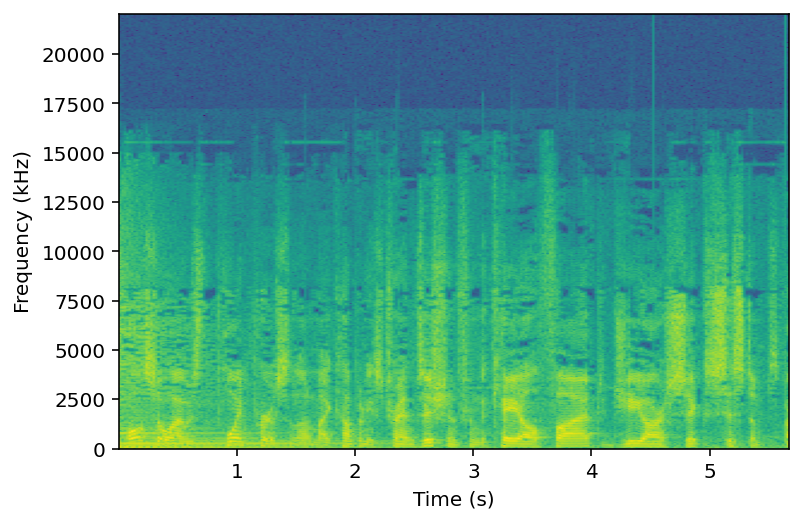

In [119]:
vis.spectogram(data, sr)

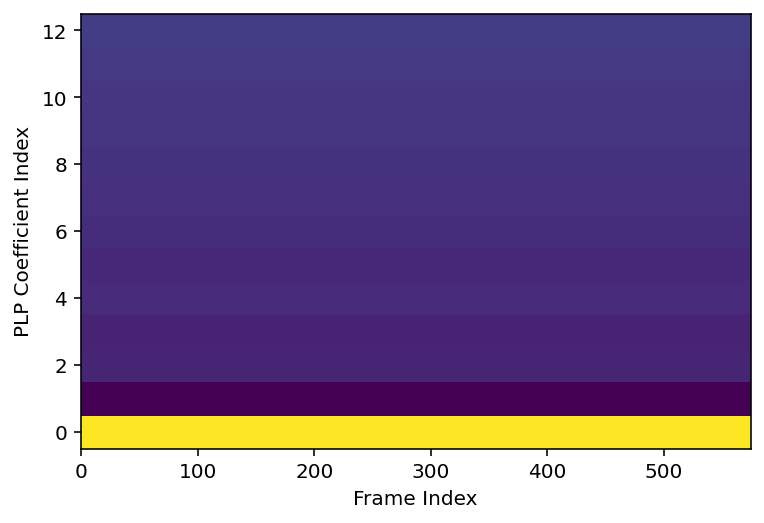

In [120]:
vis.visualize_features(plps, 'PLP Coefficient Index', 'Frame Index')

__incorrect?^__

In [121]:
rplps = rplp(data, fs = sr, normalize = 1, pre_emph = 1)

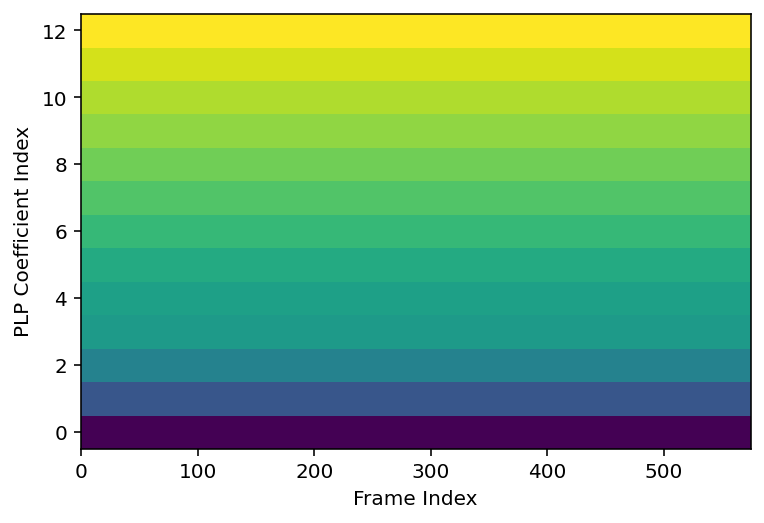

In [122]:
vis.visualize_features(rplps, 'PLP Coefficient Index', 'Frame Index')

In [124]:
plps

array([[ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847776, -0.62503733, -0.25089696, ..., -0.04493855,
        -0.01701156,  0.03744725],
       ...,
       [ 2.99847775, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725],
       [ 2.99847774, -0.62503733, -0.25089695, ..., -0.04493855,
        -0.01701157,  0.03744725]])

In [104]:
plp_scaled = np.mean(plps,axis=0)

In [105]:
plp_scaled

array([ 2.99847778, -0.62503732, -0.25089696, -0.26101539, -0.19715849,
       -0.20552327, -0.15287583, -0.13816657, -0.09817988, -0.07876333,
       -0.04493855, -0.01701158,  0.03744725])

In [21]:
# plp_list = []
# for dia, utt in zip(speaker_df['Dialogue_ID'], speaker_df['Utterance_ID']):
#     if ((dia == 125) and (utt == 3)):
#         continue
#     elif ((dia == 795) and (utt == 0)):
#         continue
#     else:
#         file = f"wav_files/train/dia{dia}_utt{utt}.wav".format(dia,utt)
#         audio,fs = librosa.load(file, sr =framerate )
#         plps = plp(audio, fs = fs, normalize = 1, pre_emph = 1)
#         plp_scaled = np.mean(plps,axis=0)
#         plp_list.append([plp_scaled])
#         print(dia, utt)

In [156]:
plp_list

[[array([ 2.99847778, -0.62503732, -0.25089696, -0.26101539, -0.19715849,
         -0.20552327, -0.15287583, -0.13816657, -0.09817988, -0.07876333,
         -0.04493855, -0.01701158,  0.03744725])],
 [array([ 2.99847777, -0.62503732, -0.25089695, -0.26101538, -0.19715849,
         -0.20552326, -0.15287583, -0.13816657, -0.09817988, -0.07876334,
         -0.04493855, -0.01701158,  0.03744724])],
 [array([ 2.99847775, -0.62503732, -0.25089695, -0.26101538, -0.19715851,
         -0.20552327, -0.15287582, -0.13816656, -0.09817988, -0.07876333,
         -0.04493855, -0.01701157,  0.03744725])],
 [array([ 2.99847779, -0.62503732, -0.25089697, -0.26101539, -0.19715846,
         -0.20552327, -0.15287582, -0.13816656, -0.09817989, -0.07876335,
         -0.04493851, -0.01701154,  0.03744723])],
 [array([ 2.99847777, -0.62503731, -0.25089695, -0.26101541, -0.19715853,
         -0.20552328, -0.15287583, -0.13816656, -0.09817986, -0.0787633 ,
         -0.04493853, -0.01701157,  0.03744724])],
 [arr

__all PLPs same values: error?__ try manually finding plps

Code: https://www.programmersought.com/article/12456696015/

In [32]:
def bark_change(x):
    return 6*np.log10(x/(1200*np.pi)+((x/(1200*np.pi))**2+1)**0.5)
def equal_loudness(x):   
    return ((x**2+56.8e6)*x**4)/((x**2+6.3e6)**2*(x**2+3.8e8))

In [54]:
f = wave.open(r"wav_files/train/dia1_utt0.wav","rb")#Put .wav in the pycharm project directory, rb is read-only
def plpcode(file,dia,utt):
    file = f"wav_files/train/dia{dia}_utt{utt}.wav".format(dia,utt)
    f = wave.open(file,"rb")
    str_data = f.readframes(nframes)#readframes returns data of string type
    signal =np.fromstring(str_data,dtype=np.int16)#Convert the string to an array of int type, my sampwidth is 2, so convert to int16
    signal_len=len(signal)
    signal=signal/(max(abs(signal)))#Normalized
    signal_add=np.append(signal[0],signal[1:]-0.97*signal[:-1]) 
    wlen=1024#Number of frames per frame signal
    inc=256#Frame shift
    N=512#Half of the number of signal frames per frame
    nf = int(np.ceil((1.0 * signal_len - wlen +
    inc) / inc))#Calculate the number of frames nf
    pad_len=int((nf-1)*inc+wlen)
    zeros=np.zeros(pad_len-signal_len)#Insufficient points are filled with 0
    pad_signal=np.concatenate((signal,zeros))
    indices=np.tile((np.arange(0,wlen)),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(wlen,1)).T
    indices=np.array(indices,dtype=np.int32)
    frames=pad_signal[indices]#Finally get the number of frames * signal data in the form of frame length
    win=np.hamming(wlen)#First call window function
    x=frames[10:] #I select a frame of data to extract the PLP coefficient, which is a row of frames
    y=win*x[0]#Get the windowed signal
    a=np.fft.fft(y)#Do fft, the default is the length of the signal, which is 1024 points
    b=np.square(abs(a[0:N])) #Find the square of the modulus of the fft transformation result, and only take half of a
    df=framerate/N  #Frequency resolution
    i=np.arange(N)#Only take the frequency greater than 0
    freq_hz=i*df#Get actual frequency coordinates
    freq_w=2*np.pi*np.array(freq_hz)#Convert to angular frequency
    freq_bark=bark_change(freq_w)# Then convert to bark frequency
    point_hz= [250, 350, 450, 570, 700, 840,1000, 1170, 1370, 1600, 1850, 2150,2500,2900,3400]
    #The number of critical frequency bands selected is generally greater than 10, covering common frequency ranges. Here I have selected 15 center frequency points
    point_w=2*np.pi*np.array(point_hz)#Convert to angular frequency
    point_bark =bark_change(point_w)#Convert to bark frequency
    bank=np.zeros((15,N))#Construct a matrix of 15 rows and 512 columns, each row is a filter vector
    filter_data=np.zeros(15)#Construct 15-dimensional band energy vector
    for j in range(15):   
        for k in range(N):     
            omg= freq_bark[k]- point_bark[j]       
            if -1.3<omg<-0.5:
                bank[j,k]=10**(2.5*(omg+0.5))       
            elif -0.5<omg<0.5:           
                bank[j,k]=1     
            elif 0.5<omg<2.5:           
                bank[j,k] = 10**(-1.0*(omg-0.5))       
            else:           
                bank[j,k]=0   
        filter_data[j] = np.sum(b * bank[j])
    equal_data=equal_loudness(point_w)*filter_data
    cubic_data=equal_data**0.33

    plp_data=np.fft.ifft(cubic_data,30)
    return plp_data

In [57]:
plp_list = []
for dia, utt in zip(speaker_df['Dialogue_ID'], speaker_df['Utterance_ID']):
    if ((dia == 125) and (utt == 3)):
        continue
    elif ((dia == 795) and (utt == 0)):
        continue
    else:
        file = f"wav_files/train/dia{dia}_utt{utt}.wav".format(dia,utt)
        plp_data = plpcode(file,dia,utt)
        plp_list.append([plp_data])
        print(dia, utt)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
5 0
5 1
5 2
5 3
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
7 0
7 1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
10 0
10 1
10 2
10 3
10 4
10 5
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
13 0
13 1
13 2
13 3
14 0
14 1
14 2
14 3
14 4
14 5
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
15 16
15 17
15 18
15 19
15 20
15 21
15 22
16 0
16 1
16 2
16 3
16 4
16 5
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
19 0
19 1
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 1

160 12
160 13
160 14
160 15
160 16
160 17
160 18
161 0
161 1
161 2
161 3
161 4
161 5
162 0
162 1
163 0
163 1
163 2
163 3
163 4
163 5
163 6
163 7
163 8
163 9
163 10
164 0
164 1
164 2
164 3
164 4
164 5
164 6
164 7
164 8
164 9
165 0
165 1
165 2
165 3
165 4
165 5
165 6
165 7
165 8
165 9
165 10
165 11
165 12
165 13
165 14
165 15
165 16
165 17
165 18
165 19
166 0
166 1
166 2
167 0
167 1
167 2
167 3
167 4
167 5
167 6
167 7
167 8
167 9
167 10
167 11
167 12
168 0
168 1
168 2
168 3
168 4
168 5
168 6
168 7
168 8
168 9
168 10
168 11
168 12
168 13
168 14
169 0
169 1
169 2
170 0
170 1
170 2
170 3
170 4
170 5
170 6
170 7
170 8
170 9
170 10
170 11
171 0
171 1
171 2
171 3
171 4
171 5
171 6
171 7
172 0
172 1
172 3
172 4
172 5
172 6
172 7
172 8
172 10
173 0
173 1
173 2
173 3
173 4
173 5
173 6
173 7
173 8
173 10
174 0
174 1
174 2
174 3
174 4
174 5
174 6
174 7
175 0
175 1
175 2
175 3
175 4
175 5
175 6
175 7
175 8
175 9
175 10
175 11
176 0
176 1
176 2
176 4
176 5
176 6
176 7
176 8
176 9
176 10
177 0
177 1
1

297 1
297 2
297 3
297 4
297 5
297 6
297 7
297 8
297 9
298 0
298 1
298 2
298 3
298 4
298 5
298 6
299 0
299 1
299 2
299 3
300 0
300 1
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
300 10
300 11
300 12
300 14
300 15
301 0
301 1
301 2
301 3
301 4
301 6
301 7
301 8
301 9
301 10
301 11
301 12
301 13
301 14
301 15
301 16
302 0
302 1
302 2
302 3
302 4
302 5
302 6
302 7
302 8
302 9
302 10
303 0
303 1
304 0
304 1
304 2
304 3
304 4
304 5
304 6
304 7
304 8
304 9
304 10
305 0
305 1
305 2
305 3
305 4
305 5
305 6
305 7
305 8
305 9
305 10
305 11
305 12
305 13
305 14
306 0
306 1
306 2
306 3
306 4
306 5
306 6
306 7
307 0
307 1
307 2
307 3
307 4
307 5
307 6
307 7
307 8
307 9
307 10
307 11
307 12
308 0
308 1
308 2
308 3
308 4
308 5
309 0
309 1
309 2
309 3
309 4
310 0
310 1
310 2
310 3
310 4
310 5
310 6
311 0
311 1
311 2
311 3
311 4
311 5
311 6
311 7
311 8
311 9
311 10
311 11
311 12
312 0
312 1
312 2
312 3
312 4
312 5
312 6
312 7
312 8
312 9
312 10
312 11
312 12
312 13
312 14
312 15
312 16
312 17
312 18


445 6
445 7
445 8
445 9
445 10
445 11
445 12
445 13
445 14
445 15
445 16
445 17
445 18
445 19
445 20
446 0
446 1
446 2
446 3
446 4
446 5
446 6
446 7
446 8
446 9
446 10
446 11
446 12
446 13
446 14
446 15
446 16
446 17
446 18
446 19
447 0
447 1
447 2
448 0
448 1
448 2
448 3
448 4
448 5
448 6
448 7
448 8
448 9
448 10
448 11
449 0
449 1
449 2
449 3
449 4
449 5
449 6
449 7
449 8
449 9
449 10
449 11
449 12
449 13
450 0
450 1
450 2
450 3
450 4
450 5
450 6
450 7
450 8
450 9
450 10
450 11
450 12
450 13
450 14
450 15
450 16
450 17
450 18
450 19
450 20
450 21
450 22
450 23
451 0
451 1
451 2
451 3
451 4
451 5
451 6
451 7
452 0
452 1
452 2
452 3
452 4
453 0
453 1
454 0
454 1
454 2
455 0
455 1
455 2
455 3
455 4
455 5
455 6
455 7
455 8
455 9
455 10
455 11
455 12
455 13
455 14
455 15
455 16
455 17
456 0
456 1
456 2
456 3
456 4
456 5
456 6
456 7
456 8
456 9
456 10
456 11
457 0
457 1
457 2
457 3
457 4
457 5
457 6
457 7
457 8
457 9
457 10
457 11
457 12
457 13
458 0
459 0
459 1
459 2
459 3
459 4
459 5
459

576 3
576 4
576 5
576 6
576 7
576 8
576 9
576 10
577 0
577 1
577 2
577 3
577 4
577 5
577 6
577 7
578 0
578 1
578 2
578 3
578 4
578 5
578 6
578 7
578 8
578 9
579 0
579 1
580 0
580 1
581 0
582 0
583 0
583 1
583 2
583 3
583 4
583 5
583 6
583 7
583 8
583 9
584 0
584 1
584 2
584 3
584 4
584 5
584 6
584 7
584 8
584 9
585 0
585 1
585 2
585 3
585 4
585 5
585 6
585 7
585 8
585 9
585 10
585 11
585 12
586 0
587 0
587 1
587 2
587 3
587 4
587 5
588 0
588 1
588 2
588 3
588 4
588 5
588 6
589 0
589 1
589 2
589 3
589 4
589 5
589 6
589 7
589 8
589 9
589 10
590 0
590 1
590 2
590 3
590 4
590 5
590 6
590 7
590 8
590 9
590 10
590 11
590 12
590 13
590 14
590 15
590 16
590 17
591 0
591 1
591 2
591 3
592 0
592 1
592 2
592 3
592 4
592 5
592 6
592 7
592 8
592 9
592 10
592 11
592 12
592 13
593 0
593 1
593 2
593 3
593 4
593 5
593 6
593 7
593 8
593 9
593 10
594 0
594 1
594 2
594 3
594 4
594 5
594 6
594 7
594 8
594 9
594 10
595 0
595 1
595 2
595 3
595 4
595 5
595 6
596 0
596 1
596 2
596 3
596 4
596 5
596 6
596 7
596

706 4
706 5
706 6
706 7
706 8
706 9
706 10
707 0
707 1
707 2
707 3
707 4
707 5
707 6
707 7
707 8
707 9
707 10
707 11
707 12
707 13
707 14
707 15
708 0
709 0
709 1
710 0
711 0
712 0
712 1
712 2
712 3
712 4
712 5
712 6
712 7
712 8
712 9
712 10
712 11
713 0
713 1
713 2
714 0
714 1
714 2
714 3
714 4
714 5
715 0
716 0
716 1
716 2
716 3
716 4
716 5
717 0
717 1
717 2
717 3
717 4
717 5
717 6
717 7
717 8
717 9
717 10
717 11
717 12
718 0
718 1
718 2
718 3
718 4
718 5
718 6
719 0
719 1
719 2
719 3
719 4
719 5
719 6
719 7
720 0
720 1
720 2
720 3
720 4
720 5
720 6
720 7
720 8
720 9
720 10
720 11
720 12
720 13
720 14
720 15
720 16
720 17
720 18
721 0
722 0
722 1
722 2
722 3
722 4
722 5
722 6
722 7
722 8
722 9
722 10
722 11
722 12
722 13
722 14
722 15
722 16
723 0
723 1
723 2
723 3
723 4
723 5
723 6
723 7
724 0
724 1
724 2
724 3
724 4
724 5
725 0
725 1
725 2
725 3
725 4
725 5
725 6
726 0
726 1
726 2
726 3
726 4
726 5
726 6
726 7
727 0
727 1
727 2
727 3
727 4
727 5
727 6
727 7
727 8
727 9
728 0
728 1


848 10
848 11
849 0
849 1
849 2
849 3
849 4
849 5
849 6
849 7
849 8
849 9
849 10
849 11
850 0
850 1
850 2
850 3
850 4
850 5
850 6
851 0
851 1
851 2
851 3
851 4
851 5
851 6
851 7
851 8
851 9
851 10
851 11
851 12
851 13
851 14
851 15
851 16
851 17
851 18
851 19
851 20
852 0
852 1
852 2
852 3
852 4
852 5
852 6
852 7
852 8
853 0
853 1
853 2
853 3
853 4
853 5
853 6
853 7
853 8
853 9
853 10
853 11
853 12
853 13
853 14
854 0
854 1
854 2
854 3
854 4
854 5
855 0
855 1
855 2
855 3
855 4
855 5
855 6
855 7
856 0
856 1
856 2
856 3
856 4
857 0
857 1
857 2
857 3
857 4
857 5
857 6
857 7
857 8
857 9
857 10
857 11
858 0
858 1
858 2
858 3
858 4
858 5
858 6
858 7
858 8
858 9
858 10
858 11
858 12
858 13
859 0
859 1
859 2
859 3
860 0
860 1
860 2
860 3
860 4
860 5
860 6
860 7
860 8
860 9
860 10
860 11
860 12
860 13
860 14
860 15
861 0
861 1
861 2
861 3
861 4
861 5
861 6
861 7
861 8
861 9
861 10
861 11
861 12
861 13
861 14
861 15
861 16
861 17
861 18
862 0
862 1
862 2
862 3
863 0
863 1
863 2
863 3
863 4
863 5

979 6
980 0
980 1
980 2
980 3
980 4
980 5
980 6
980 7
980 8
980 9
980 10
980 11
981 0
981 1
981 2
981 3
981 4
982 0
982 1
982 2
982 3
982 4
982 5
982 6
982 7
982 8
982 9
982 10
983 0
983 1
983 2
983 3
983 4
983 5
983 6
983 7
984 0
984 1
984 2
984 3
984 4
984 5
985 0
985 1
985 2
985 3
985 4
986 0
986 1
986 2
986 3
986 4
986 5
986 6
986 7
986 8
986 9
986 10
986 11
986 12
986 13
986 14
986 15
986 16
987 0
988 0
988 1
988 2
988 3
988 4
988 5
988 6
988 7
989 0
989 1
989 2
989 3
989 4
989 5
989 6
989 7
989 8
989 9
989 10
989 11
990 0
990 1
990 2
990 3
990 4
990 5
990 6
990 7
990 8
990 9
990 10
990 11
990 12
990 13
990 14
990 15
990 16
990 17
990 18
990 19
991 0
991 1
991 2
991 3
991 4
991 5
991 6
991 7
991 8
991 9
991 10
991 11
991 12
991 13
991 14
992 0
992 1
992 2
992 3
992 4
992 5
992 6
992 7
992 8
992 9
992 10
992 11
992 12
992 13
992 14
992 15
993 0
993 1
993 2
993 3
994 0
994 1
994 2
994 3
994 4
994 5
994 6
995 0
995 1
996 0
996 1
996 2
996 3
996 4
996 5
996 6
996 7
996 8
996 9
996 10


In [59]:
len(plp_list)

9987

In [62]:
plp_df = pd.DataFrame(plp_list)
plp_df.rename(columns = {0:'plp'}, inplace = True)

In [63]:
plp_df

,plp
0,"[(1.67989276626406+0j), (0.05969540081940529+1..."
1,"[(0.34830745234976074+0j), (-0.042764075416004..."
2,"[(0.2793877673677046+0j), (-0.0169999525988548..."
3,"[(0.34973647569415256+0j), (0.0016085391753264..."
4,"[(0.3259941384928669+0j), (-0.0189140008172783..."
...,...
9982,"[(1.6470206949148012+0j), (-0.2535719509739221..."
9983,"[(0.35555189156229744+0j), (0.0053249707606566..."
9984,"[(0.9755968118118419+0j), (0.09239352568760967..."
9985,"[(0.255125816970881+0j), (0.002275629675157485..."


In [64]:
plp_main = pd.concat([speaker_df ,pd.DataFrame(plp_df['plp'].values.tolist())],axis=1)
plp_main.head()

,Speaker,Dialogue_ID,Utterance_ID,0,1,2,3,4,5,6,...,20,21,22,23,24,25,26,27,28,29
0,Chandler,0,0,1.679893+0.000000j,0.059695+1.080678j,-0.005679+0.093159j,-0.162648+0.408548j,-0.100514-0.239266j,0.167724+0.147011j,0.000723-0.027754j,...,-0.037056+0.021158j,0.112677-0.085436j,-0.052135+0.045466j,0.090560-0.156721j,0.000723+0.027754j,0.167724-0.147011j,-0.100514+0.239266j,-0.162648-0.408548j,-0.005679-0.093159j,0.059695-1.080678j
1,The Interviewer,0,1,0.348307+0.000000j,-0.042764+0.233599j,-0.026455-0.055693j,0.025829+0.056518j,-0.001399-0.015644j,0.019054+0.043356j,-0.011248-0.011177j,...,-0.008990+0.006491j,0.020142-0.015195j,-0.010725+0.008410j,0.019344-0.025166j,-0.011248+0.011177j,0.019054-0.043356j,-0.001399+0.015644j,0.025829-0.056518j,-0.026455+0.055693j,-0.042764-0.233599j
2,Chandler,0,2,0.279388+0.000000j,-0.017000+0.172510j,0.013922-0.034978j,0.027868+0.074152j,-0.008225-0.005629j,0.019112+0.034964j,-0.003120-0.004979j,...,-0.004338+0.003269j,0.019812-0.015927j,-0.005022+0.004463j,0.018817-0.024896j,-0.003120+0.004979j,0.019112-0.034964j,-0.008225+0.005629j,0.027868-0.074152j,0.013922+0.034978j,-0.017000-0.172510j
3,The Interviewer,0,3,0.349736+0.000000j,0.001609+0.229655j,-0.012781-0.006974j,0.007710+0.073274j,-0.011989-0.005898j,0.006466+0.041450j,-0.014092-0.013174j,...,-0.010752+0.001093j,0.021772-0.017058j,-0.008327+0.009420j,0.016438-0.021849j,-0.014092+0.013174j,0.006466-0.041450j,-0.011989+0.005898j,0.007710-0.073274j,-0.012781+0.006974j,0.001609-0.229655j
4,Chandler,0,4,0.325994+0.000000j,-0.018914+0.200003j,0.025592-0.017055j,-0.006914+0.107214j,-0.026711-0.023124j,0.003898+0.043207j,-0.015209-0.026804j,...,-0.017491+0.009624j,0.022854-0.022609j,-0.013612+0.015740j,0.020312-0.029237j,-0.015209+0.026804j,0.003898-0.043207j,-0.026711+0.023124j,-0.006914-0.107214j,0.025592+0.017055j,-0.018914-0.200003j


In [66]:
cast = ['Ross', 'Chandler', 'Joey', 'Phoebe', 'Rachel', 'Monica']
plp_main = plp_main[plp_main['Speaker'].isin(cast)]
plp_main['Speaker'].value_counts()

Joey        1510
Ross        1456
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Name: Speaker, dtype: int64

In [67]:
plp_main.isnull().sum().sum()

0

In [68]:
#plp_main.to_csv('plp_main.csv', index = False)

In [69]:
features = plp_main.drop(['Speaker', 'Dialogue_ID', 'Utterance_ID'], axis = 1)

In [70]:
features

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.679893+0.000000j,0.059695+1.080678j,-0.005679+0.093159j,-0.162648+0.408548j,-0.100514-0.239266j,0.167724+0.147011j,0.000723-0.027754j,0.090560+0.156721j,-0.052135-0.045466j,0.112677+0.085436j,...,-0.037056+0.021158j,0.112677-0.085436j,-0.052135+0.045466j,0.090560-0.156721j,0.000723+0.027754j,0.167724-0.147011j,-0.100514+0.239266j,-0.162648-0.408548j,-0.005679-0.093159j,0.059695-1.080678j
2,0.279388+0.000000j,-0.017000+0.172510j,0.013922-0.034978j,0.027868+0.074152j,-0.008225-0.005629j,0.019112+0.034964j,-0.003120-0.004979j,0.018817+0.024896j,-0.005022-0.004463j,0.019812+0.015927j,...,-0.004338+0.003269j,0.019812-0.015927j,-0.005022+0.004463j,0.018817-0.024896j,-0.003120+0.004979j,0.019112-0.034964j,-0.008225+0.005629j,0.027868-0.074152j,0.013922+0.034978j,-0.017000-0.172510j
4,0.325994+0.000000j,-0.018914+0.200003j,0.025592-0.017055j,-0.006914+0.107214j,-0.026711-0.023124j,0.003898+0.043207j,-0.015209-0.026804j,0.020312+0.029237j,-0.013612-0.015740j,0.022854+0.022609j,...,-0.017491+0.009624j,0.022854-0.022609j,-0.013612+0.015740j,0.020312-0.029237j,-0.015209+0.026804j,0.003898-0.043207j,-0.026711+0.023124j,-0.006914-0.107214j,0.025592+0.017055j,-0.018914-0.200003j
6,0.526462+0.000000j,-0.019820+0.347480j,-0.026799-0.035700j,0.020955+0.094332j,0.003063-0.017194j,0.023822+0.079427j,-0.026409-0.010833j,0.023061+0.038565j,-0.021090-0.011070j,0.027103+0.020822j,...,-0.015190+0.007602j,0.027103-0.020822j,-0.021090+0.011070j,0.023061-0.038565j,-0.026409+0.010833j,0.023822-0.079427j,0.003063+0.017194j,0.020955-0.094332j,-0.026799+0.035700j,-0.019820-0.347480j
8,0.611542+0.000000j,-0.084022+0.389640j,0.008815-0.105089j,0.047155+0.158557j,-0.030059-0.022914j,0.020839+0.078193j,-0.021846-0.032823j,0.038605+0.055709j,-0.028342-0.016338j,0.034543+0.033284j,...,-0.028077+0.016038j,0.034543-0.033284j,-0.028342+0.016338j,0.038605-0.055709j,-0.021846+0.032823j,0.020839-0.078193j,-0.030059+0.022914j,0.047155-0.158557j,0.008815+0.105089j,-0.084022-0.389640j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,3.104254+0.000000j,0.108200+2.248100j,-0.606754+0.081454j,-0.004129+0.280373j,-0.137157+0.023995j,-0.069268+0.147890j,-0.030559-0.148480j,0.110967+0.165104j,-0.089625-0.059858j,0.128091+0.081762j,...,-0.082308-0.000730j,0.128091-0.081762j,-0.089625+0.059858j,0.110967-0.165104j,-0.030559+0.148480j,-0.069268-0.147890j,-0.137157-0.023995j,-0.004129-0.280373j,-0.606754-0.081454j,0.108200-2.248100j
9982,1.647021+0.000000j,-0.253572+1.155788j,-0.232914-0.283795j,0.094573+0.217217j,-0.063778-0.075930j,0.036753+0.126674j,-0.030068-0.101659j,0.095725+0.114125j,-0.060131-0.048805j,0.093884+0.065264j,...,-0.057418+0.023370j,0.093884-0.065264j,-0.060131+0.048805j,0.095725-0.114125j,-0.030068+0.101659j,0.036753-0.126674j,-0.063778+0.075930j,0.094573-0.217217j,-0.232914+0.283795j,-0.253572-1.155788j
9983,0.355552+0.000000j,0.005325+0.247291j,-0.055120-0.013089j,0.023078+0.019841j,0.020462+0.002194j,0.009837+0.036881j,0.007585-0.012240j,0.023861+0.032286j,-0.006898-0.004492j,0.025326+0.013530j,...,-0.002082-0.002949j,0.025326-0.013530j,-0.006898+0.004492j,0.023861-0.032286j,0.007585+0.012240j,0.009837-0.036881j,0.020462-0.002194j,0.023078-0.019841j,-0.055120+0.013089j,0.005325-0.247291j
9984,0.975597+0.000000j,0.092394+0.678604j,-0.118582+0.085643j,-0.026795+0.161341j,-0.077373-0.002445j,-0.001721+0.045113j,-0.016881-0.025263j,0.030461+0.043605j,-0.018516-0.010477j,0.033109+0.029754j,...,-0.020719+0.004809j,0.033109-0.029754j,-0.018516+0.010477j,0.030461-0.043605j,-0.016881+0.025263j,-0.001721-0.045113j,-0.077373+0.002445j,-0.026795-0.161341j,-0.118582-0.085643j,0.092394-0.678604j


In [71]:
X_plp = np.array(features)

In [72]:
y_plp = np.array(plp_main['Speaker'].tolist())

In [73]:
y_plp

array(['Chandler', 'Chandler', 'Chandler', ..., 'Ross', 'Joey', 'Joey'],
      dtype='<U8')

In [74]:
lb = LabelEncoder()

In [75]:
label_y = to_categorical(lb.fit_transform(y_plp))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_plp, label_y, test_size = 0.2, random_state = 0)

In [77]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

In [86]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 30, 256)           2304      
_________________________________________________________________
activation_44 (Activation)   (None, 30, 256)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 30, 256)           524544    
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 256)           1024      
_________________________________________________________________
activation_45 (Activation)   (None, 30, 256)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 256)           

In [87]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

52/52 [==============================] - 2s 24ms/step - loss: 5.2100 - accuracy: 0.1719
Pre-training accuracy: 17.5798%


In [88]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='lpc_model.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
26/26 [==============================] - 23s 855ms/step - loss: 6.5530 - accuracy: 0.1591 - val_loss: 9.5684 - val_accuracy: 0.1577

Epoch 00001: val_loss improved from inf to 9.56844, saving model to lpc_model.hdf5
Epoch 2/72
26/26 [==============================] - 20s 746ms/step - loss: 3.9438 - accuracy: 0.1627 - val_loss: 3.6142 - val_accuracy: 0.1704

Epoch 00002: val_loss improved from 9.56844 to 3.61424, saving model to lpc_model.hdf5
Epoch 3/72
26/26 [==============================] - 24s 915ms/step - loss: 8.4461 - accuracy: 0.1742 - val_loss: 8.7571 - val_accuracy: 0.1704

Epoch 00003: val_loss did not improve from 3.61424
Epoch 4/72
26/26 [==============================] - 20s 787ms/step - loss: 8.4020 - accuracy: 0.1772 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00004: val_loss did not improve from 3.61424
Epoch 5/72
26/26 [==============================] - 27s 1s/step - loss: 7.5268 - accuracy: 0.1849 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00005


Epoch 00042: val_loss did not improve from 3.61424
Epoch 43/72
26/26 [==============================] - 22s 833ms/step - loss: 7.5265 - accuracy: 0.1826 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00043: val_loss did not improve from 3.61424
Epoch 44/72
26/26 [==============================] - 21s 810ms/step - loss: 7.5265 - accuracy: 0.1865 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00044: val_loss did not improve from 3.61424
Epoch 45/72
26/26 [==============================] - 22s 838ms/step - loss: 7.5265 - accuracy: 0.1865 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00045: val_loss did not improve from 3.61424
Epoch 46/72
26/26 [==============================] - 21s 826ms/step - loss: 7.5265 - accuracy: 0.1859 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00046: val_loss did not improve from 3.61424
Epoch 47/72
26/26 [==============================] - 22s 832ms/step - loss: 7.5265 - accuracy: 0.1840 - val_loss: 7.7728 - val_accuracy: 0.1704

Epoch 00047: val_lo

In [89]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.1847057044506073
Testing Accuracy:  0.17037929594516754


__PLP has a higher accuracy than both LPC and MFCC on same CNN model__